<img src="https://www.saperessere.com/wp-content/uploads/2013/08/logo-sapienza-new.jpg" width="300"/>

# Directions and information from this notebook

The aim of this notebook is to produce the synthetic dataset of BLENDER to be used and analized in posterior stages.

Inside of this notebook is written the whole code to program the data generation and some analysis that is used to verify the integrity of the data (Exploratory Data Analysis).


# Import libraries

In [ ]:
import time
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'
import numpy as np
from numpy import cos, sin, arcsin, sqrt
from math import radians, ceil
import matplotlib.pyplot as plt
import plotly.express as px
from tqdm import tqdm
import datetime
from datetime import date, timedelta
from IPython.display import clear_output
import seaborn as sns
import hashlib
import sqlite3

sns.set(style="darkgrid", rc = {'figure.figsize':(5,7)})

from google.colab import drive
# Mount drive from Google
drive.mount('/content/gdrive')

Mounted at /content/gdrive


# Define parameters

Within this parameter's definition, the aim is to be able to run the code easily, only by changing the location where the whole data is (or will be) stored.

In [ ]:
# Define paths
root_path = '/content/gdrive/MyDrive/Students_honour_programme/project_with_professor_Francesca_Cuomo'
%cd $root_path

output_path = root_path + '/output'
# models_path = root_path + '/models'

# Define random state for reproducibility
random_state = 0

# Define colors to use in plots
colors = ["#00cfcc"]

/content/gdrive/MyDrive/Students_honour_programme/project_with_professor_Francesca_Cuomo


# Define functions

In the following cell I left the functions' definition used. Each one of them have their own explanation.

In [ ]:
# Calculate haversine distance
def haversine(row, from_lat, from_lon):
  """
  Get the distance from coordinate to another using latitude and longitude and the haversine distance
  :row: Row od the dataframe
  :from_lat: Latitude of the initial coordinate
  :from_lon: Longitude of the initial coordinate

  :return km: Distance in kilometers
  """
  # Define longitude and latitude of the final station
  to_lon = row['longitude']
  to_lat = row['latitude']
  
  # Map to radians the longitude and latitude
  from_lon, from_lat, to_lon, to_lat = map(radians, [from_lon, from_lat, to_lon, to_lat])
  
  # Get difference between longitudes
  dlon = to_lon - from_lon 

  # Get difference between latitudes
  dlat = to_lat - from_lat 

  # Perform calculation
  a = sin(dlat/2)**2 + cos(from_lat) * cos(to_lat) * sin(dlon/2)**2
  c = 2 * arcsin(sqrt(a)) 
  
  # Convert to kilometers using 6367 as the radio of the earth
  km = 6367 * c
  return km

# Normalize hours in defined range
def normalize_hours(random_numbers, NewMin, NewMax):
  """
  Get the hour normalazied in a determined range
  :random_numbers: Get the numbers generated as hour
  :NewMin: Minimum value of time
  :NewMax: Maximum value of time

  :return random_numbers: Normalized hour
  """
  # OldMax = max(random_numbers)
  # OldMin = min(random_numbers)
  # OldMax = 3
  # OldMin = 21

  # OldRange = (OldMax - OldMin)  
  # NewRange = (NewMax - NewMin)  
  # random_numbers = (((random_numbers - OldMin) * NewRange) / OldRange) + NewMin
  random_numbers = np.where(random_numbers>23.9999,23.9999, 
                            np.where(random_numbers<0,0.0,
                                    random_numbers))
  return random_numbers


def week_of_month(dt):
    """ Returns the week of the month for the specified date.
    :dt: Datetime

    :return adjusted_dom: Week of the month in number
    """

    # Force the first day
    first_day = dt.replace(day=1)

    # Get day of month
    dom = dt.day
    
    # Adjust the date to the corresponding week
    adjusted_dom = dom + first_day.weekday()

    return int(ceil(adjusted_dom/7.0))

# Load data

The data **stations_geocoded.csv** contains the 130 selected places to be treated as stations after geocoding them with the Nobook called *01_Geolocalize stations.ipynb*.

In [ ]:
# Read stations
stations = pd.read_csv("data/stations_geocoded.csv", sep=";", encoding='utf-8', dtype = {"station_id" : "str"})
# stations = stations.head(5)
stations

,station_id,place_name,address,city,country,type,latitude,longitude,weights
0,3001,The Colosseum,"Piazza del Colosseo, 1, 00184 Roma RM",Rome,Italy,Building,41.890542,12.492317,3.0
1,3004,Altare della patria,"Piazza di S. Marco, 4289, 00186 Roma RM",Rome,Italy,Building,41.894576,12.483123,2.0
2,3006,Arch of Constantine,"Via di San Gregorio, 00186 Roma RM",Rome,Italy,Building,41.889737,12.490887,2.0
3,3046,Villa Pamphilj,"Via Aurelia Antica, 12, 00164 Roma RM",Rome,Italy,Park,41.888992,12.444942,0.7
4,3101,Manzoni Station,"Viale Manzoni, 10, 00185 Roma RM",Rome,Italy,Subway station,41.890281,12.506206,1.5
...,...,...,...,...,...,...,...,...,...
125,3096,Tiburtina Station,"Tiburtina, Roma RM",Rome,Italy,Subway station,41.903167,12.531896,1.5
126,3097,Circo Massimo station Station,"Circo Massimo, Roma RM",Rome,Italy,Subway station,41.886158,12.485309,0.9
127,3098,Trastevere Railway,"Roma Trastevere, Roma RM",Rome,Italy,Train Station,41.872138,12.465076,0.9
128,3099,Saint Pietro Railway,"Roma San Pietro, Roma RM",Rome,Italy,Train Station,41.896066,12.454465,0.6


# Obtain the number of devices for each station

In the next three cells, I'm generating the number of devices per station that the whole data will consider.

In [ ]:
# Define number of stations
n_stations = stations.shape[0]

# Define the expected number devices in the stations in one month
mu_dev = 12000
# mu_dev = 5000

# Get random numbers with Poisson distribution
np.random.seed(random_state)
number_devices = np.random.poisson(mu_dev, n_stations)

print("Number of devices:",np.sum(number_devices))
print("Mean:",np.mean(number_devices))
print("Median:",np.median(number_devices))
print("Standard Deviation:",np.std(number_devices))

Number of devices: 1560181
Mean: 12001.392307692307
Median: 12007.0
Standard Deviation: 98.99592036301652


Number of devices: 1679411
Mean: 12918.546153846153
Median: 8482.0
Standard Deviation: 9599.143629360933


(array([0.e+00, 2.e-05, 4.e-05, 6.e-05, 8.e-05, 1.e-04]),
 <a list of 6 Text major ticklabel objects>)

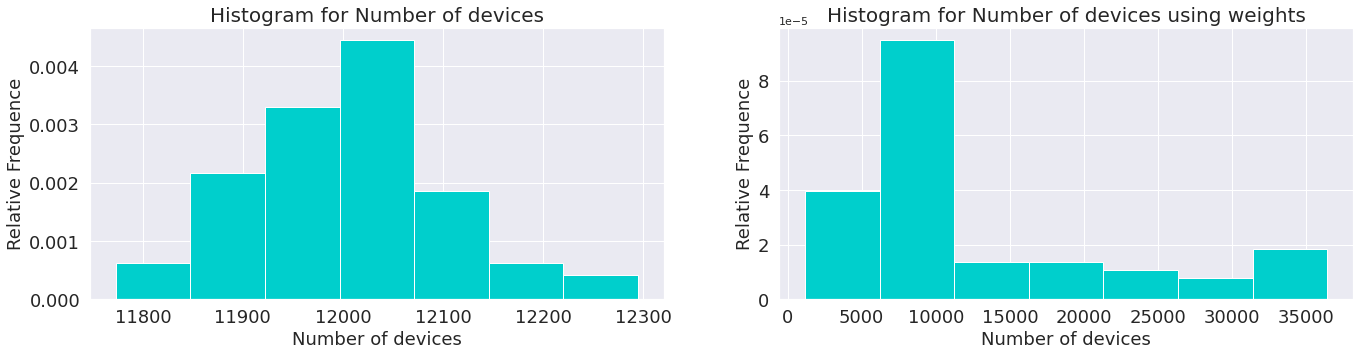

In [ ]:
# Generate the number of devices per station
stations['nd'] = (stations.weights * number_devices).astype(int)

print("Number of devices:",np.sum(stations['nd']))
print("Mean:",np.mean(stations['nd']))
print("Median:",np.median(stations['nd']))
print("Standard Deviation:",np.std(stations['nd']))

f, axs = plt.subplots(2,2,figsize=(35,5))
plt.subplot(1, 3, 1)
plt.hist(number_devices,alpha = 1, label='Train', density=True, bins = 7, color=colors[0])
plt.xlabel('Number of devices', fontsize=18)
plt.ylabel('Relative Frequence', fontsize=18)
plt.title(r'Histogram for Number of devices', fontsize=20)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.subplot(1, 3, 2)
plt.hist(stations['nd'],alpha = 1, density=True, bins = 7, color=colors[0])
plt.xlabel('Number of devices', fontsize=18)
plt.ylabel('Relative Frequence', fontsize=18)
plt.title(r'Histogram for Number of devices using weights', fontsize=20)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)

In [ ]:
# Define token from mapbox
px.set_mapbox_access_token(open(root_path + "/data/mapbox_token.txt").read())

# Define map
fig = px.scatter_mapbox(stations,
                        lat=stations.latitude,
                        lon=stations.longitude,
                        hover_name="place_name",
                        width=1200,
                        height=800,
                        zoom=11.3,
                        color="type", size="nd",
                        color_discrete_sequence = px.colors.qualitative.Light24, size_max = 30,
                        opacity = 0.7
                        )

fig.update_layout(legend_font_size=20, hoverlabel=dict(font=dict(family='sans-serif', size=20)))

fig.show()

# Obtain the fingerprint for each device and the paths followed by each one

The following code it is generated the synthetic data per se. The code contains the logic employed after understanding the BLENDER procedure proposed by Massimo Perri. This code works with some defined parameters that can be found and explained in the file Parameters definition for BLENDER synthetic data.xlsx.

## Calculate Haversine distance from all to all stations

In [ ]:
start_time = time.time()
# Get a copy of all the stations to select devices from
st_select_from = stations.copy()

# Define Empty dataframe
df_distances = pd.DataFrame(columns=st_select_from.columns.to_list()+ ['distance','from_station_id'])

# Iterate to calculate distance of all stations 
for i in tqdm(range(st_select_from.shape[0])):
  # Get the desired station
  current_station = st_select_from.loc[i]

  # Define latitude and longitude of current station
  from_lat = current_station.latitude
  from_lon = current_station.longitude

  # Calculate distance with haversine distance (in km)
  st_select_from['distance'] = st_select_from.apply(lambda row: haversine(row, from_lat, from_lon), axis=1)
  
  # Add the station_id from where the distance where measured
  st_select_from['from_station_id'] = current_station.station_id

  # Sort values to have the closest on first
  st_select_from = st_select_from.sort_values(by=['distance'])

  # Append results in final distance dataframe
  df_distances = pd.concat([df_distances, st_select_from], axis=0)
  
# Reset indexes
df_distances = df_distances.reset_index(drop=True)

print("\nExecution time: %s seconds" % (time.time() - start_time))

100%|██████████| 130/130 [00:01<00:00, 105.08it/s]


Execution time: 1.2487964630126953 seconds


## Generate synthethic devices fingerprint and paths

The following cell may take between 2 to 4 hours to run. For that reason, it is recommended to leave the flag `rerun_data_generation` as `False`, in the case that you want only to load the already generated data. On the other hand, if you want to regenerate the whole data, then the next cell can be run by changing the `rerun_data_generation` to `True`.

In [ ]:
# Flag to define if the data should be generated again (False: the data will be not generated, only loaded in the following cell, True: the data will be generated again (takes long to run))
rerun_data_generation = False

if rerun_data_generation:
  # Get a copy of all the stations to select devices from
  st_select_from = stations.copy()

  # Define random state to run loops (make it change each iteration)
  random_state_loop = random_state

  # Initialize counter of iterations
  cont = 0

  # Define Empty dataframe to store the whole data
  cols_to_keep = ['station_id','fingerprint_id','latitude','longitude','received_at','nd','type','address','place_name']
  data_merged = pd.DataFrame(columns=cols_to_keep)

  # Initialize the stations remaining to find devices
  stations_remaining = st_select_from.station_id

  # Define fingerprint_id to check if needed
  fingerprint_id_check = '0000000000001'

  start_time = time.time()
  # while cont <= 10:
  while st_select_from.shape[0] > 0:
    # Select randomly one station to locate the device
    current_station = st_select_from.sample(n = 1, random_state=random_state).reset_index(drop=True)

    # Select the distances from initial station
    current_distances = df_distances.loc[df_distances.from_station_id == current_station.station_id.iloc[0]]

    # Remove from the distance the stations that shouldn't be used since the correspondent number of devices where already generated 
    current_distances = current_distances.loc[current_distances['station_id'].isin(stations_remaining)]

    # Check if the number of remaining stations is greater than 1
    if current_distances.shape[0] > 1:

      # Remove first row that contains the same initial and final station
      current_distances = current_distances.iloc[1:, :]

      # Define average number of stations visited per device in one month
      mu_sta_visit = 10

      # Define number of stations that the device visited
      np.random.seed(random_state_loop)
      n_sta_visited = np.random.poisson(mu_sta_visit, 1)[0] + 1 # Adding 1 to avoid 0 stations visited

      # Define weigths to perform Probability-proportional-to-size (PPS) sampling
      current_distances['PPS_weight'] = max(current_distances.distance) - current_distances.distance + 0.01

      # Check if the sample size is bigger than the current number of available stations
      if n_sta_visited < current_distances.shape[0]:
        # Perform PPS to select the stations visited proportional to the distance of the initial station
        visited_stations = current_distances.sample(n = n_sta_visited,  weights='PPS_weight', random_state = random_state_loop
                                                    # , replace = True
                                                    ).sort_values(by=['distance'])
      else:
        # Select all the current distances instead of taking sample
        visited_stations = current_distances

      # Select the number of stations to be removed
      np.random.seed(random_state_loop)
      n_sta_remove = np.random.randint(0, high = max(1, n_sta_visited - 3), size=1, dtype=int)[0] # The 3 number is to remove just a few stations 

      # Remove random stations to simulate non-produced fingerprint in some stations
      np.random.seed(random_state_loop)
      drop_indices = np.random.choice(visited_stations.index, n_sta_remove)
      visited_stations = visited_stations.drop(drop_indices).reset_index(drop=True)

    else:
      # Select all the current distances
      visited_stations = current_distances

    # Define shape for gamma distribution
    shape = 10
    


    # Define desired mean for time and probabilities of selection depending on the type of station
    if current_station.type.iloc[0] == 'Church':
      # Define the mean desired
      mu_desired = 10
      # Define the weight for each day of the week
      # p_day = [0.2,0.13,0.01,0.01,0.05,0.15,3]
      p_day = [15,0.5,0.5,0.5,1,20,20]
    elif current_station.type.iloc[0] == 'Dance club':
      # Define the mean desired
      mu_desired = 24
      # Define the weight for each day of the week
      # p_day = [0,0,0,0.15,0.1,0.1,0.12]
      p_day = [0,0,0,0.5,1,20,20]
    elif current_station.type.iloc[0] == 'Subway station' or current_station.type.iloc[0] == 'Train Station' or current_station.type.iloc[0] == 'Bus Stop':
      # Define the mean desired
      mu_desired = 8
      # Define the weight for each day of the week
      # p_day = [0.7,0.3,0.2,0.01,0.023,0.1,0.001]
      p_day = [15,0.5,0.5,0.5,1,20,20]
    else:
      # Define the mean desired
      mu_desired = 8
      # Define the weight for each day of the week
      # p_day = [0.9,0.2,0.2,0.01,0.03,0.19,0.07]
      p_day = [15,0.5,0.5,0.5,1,20,20]

    # Calculate the scale parameter for gamma distribution
    scale = mu_desired / shape

    # Randomly choose the hour of the current station
    np.random.seed(random_state_loop)
    initial_hour = np.random.gamma(shape, scale, 1)

    # Normalize values obtained
    initial_hour = normalize_hours(initial_hour, 6, 24)
    initial_hour = str(datetime.timedelta(hours=initial_hour[0]))

    # Define starting minimum possible date
    sdate = date(2022,3,1) 

    # Define starting maximum possible date
    edate = date(2022,4,1)

    # Generate all the days existing in the range of days (one week)
    dates_range = pd.date_range(sdate,edate-timedelta(days=1),freq='d')

    # Convert dates to get the day of the week correspondend
    weekday_range = dates_range.to_series().dt.dayofweek.to_list()

    # Set the number of the week days (0:Monday to 6:Sunday)
    seq_weekdays = list(range(0, 7))

    # Define dictionary to loop into
    dict_weekday = dict(zip(seq_weekdays, p_day))
    
    # Find the weight to use
    p_date = [v for d in weekday_range for k,v in dict_weekday.items() if k == d]
    
    # Normalize between 0 and 1
    p_date = p_date / np.sum(p_date)
    
    # Select date subject to probabilities defined previously
    np.random.seed(random_state_loop)
    current_date = pd.to_datetime(np.random.choice(dates_range, 1, p=p_date)[0]).date()

    # Define speed of the person (device) in kilometers/hour

    # Define shape of gamma distribution
    shape_speed = 0.4

    # Define desired mean 
    mu_desired_speed = 5

    # Calculate scale parameter of gamma distribution
    scale_speed = mu_desired_speed / shape_speed

    # Randomly select the speed of the device (person)
    np.random.seed(random_state_loop)
    visited_stations['speed'] = np.random.gamma(shape_speed, scale_speed, 1)[0] + 1

    # Calculate transit time in minutes
    visited_stations['time'] = visited_stations['distance'] * 60 / visited_stations['speed']

    # Get the complete date of the initial station
    visited_stations['initial_date_time'] = datetime.datetime.strptime(str(current_date) + " " + initial_hour, '%Y-%m-%d %H:%M:%S.%f')

    # Define the reception time of the signal
    visited_stations['received_at'] = visited_stations['initial_date_time'] + pd.to_timedelta(visited_stations['time'],'m')

    # Generate the fingerprint_id
    fingerprint_id = str(cont+1).zfill(13)
    
    # Add the device id to visited and initial stations
    visited_stations['fingerprint_id'] = fingerprint_id
    current_station ['fingerprint_id'] = fingerprint_id

    # Define the reception time of the signal for the initial station
    current_station['received_at'] = datetime.datetime.strptime(str(current_date) + " " + initial_hour, '%Y-%m-%d %H:%M:%S.%f')

    # Merge current station and visited stations
    current_path = pd.concat([current_station, visited_stations], axis=0).reset_index(drop=True)
    
    # Add checher file
    if current_path['fingerprint_id'][0] == fingerprint_id_check:
      checker1 = current_path

    # Define probability of repetition
    p_repeat_patt = 0.6
    
    # Generate random flag to decide if replicate path in next day  or not
    np.random.seed(random_state_loop)
    repeat_patt_flag = np.random.binomial(size=1, n=1, p= p_repeat_patt)

    # Decide if replicate path in next days or not
    if (repeat_patt_flag == 1) and (not current_station.received_at.dt.day_name().isin(['Saturday','Sunday'])[0]):
    # if (repeat_patt_flag == 1):
      
      # Repeat patterns from morning to afternoon

      # Get a copy of the current path to store repetitions
      current_path_merg_aftern = current_path.copy()

      # Replicate current path (visited stations)
      current_path_new = current_path.copy()

      # Generate difference of hours for patter morning/afternoon
      np.random.seed(random_state_loop)
      hours_add = np.random.choice([8,9,10,11,12,13,14], 1, p =[0.05,0.05,0.1,0.15,0.2,0.2,0.25])[0]
    

      # Generate random differences of time (in minutes)
      np.random.seed(random_state_loop)
      current_path_new['diff_time'] = np.random.uniform(-10,10, 1)[0]

      # Add hours and some random minutes (psotive and negative) to the current path
      current_path_new['received_at'] = current_path_new['received_at'] + pd.to_timedelta(hours_add,'h')

      # Reverse order of arrival time to simulate "returning" pattern
      current_path_new['received_at'] = current_path_new.received_at.iloc[::-1].reset_index(drop=True)

      # Merge each repetition
      current_path_merg_aftern = pd.concat([current_path_merg_aftern, current_path_new], axis=0).reset_index(drop=True)

      # Add checher file
      if current_path['fingerprint_id'][0] == fingerprint_id_check:
        checker2 = current_path
        checker3 = current_path_new
        checker4 = current_path_merg_aftern





      # Repeat patterns along the days
      # Get the current week day
      current_week_day = current_station['received_at'][0].weekday()

      # Define days from 0:Sunday to 6:Saturday
      days = list(range(7))

      # Get the days to add/extract depending on the day
      days_to_add = [24*(x - current_week_day) for x in days][0:5]

      # Get only those different that 0 to avoid repeating the same day
      days_to_add = [i for i in days_to_add if i != 0]
      
      # Get a copy of the current path to store repetitions
      current_path_merg_days = current_path_merg_aftern.copy()
      
      for i in range(len(days_to_add)):

        # Replicate current path (visited stations)
        current_path_new = current_path_merg_aftern.copy()

        # Generate random differences of time (in minutes)
        np.random.seed(random_state_loop)
        current_path_new['diff_time'] = np.random.uniform(-10,10, current_path_new.shape[0])
        
        # Take the number of days to add depending on the current day 
        repeat_hours = days_to_add[i]

        # Add hours and some random minutes (psotive and negative) to the current path
        current_path_new['received_at'] = current_path_new['received_at'] + pd.to_timedelta(repeat_hours,'h') + pd.to_timedelta(current_path_new['diff_time'],'m')

        # Keep only dates in the possible range defined
        current_path_new = current_path_new.loc[(current_path_new['received_at'] <= np.datetime64(edate)) & (current_path_new['received_at'] >= np.datetime64(sdate))]

        # Merge each repetition
        current_path_merg_days = pd.concat([current_path_merg_days, current_path_new], axis=0).reset_index(drop=True)
        
        # Add value to change the random state of the loop
        random_state_loop = random_state_loop + 100

      # Add checher file
      if current_path['fingerprint_id'][0] == fingerprint_id_check:
        checker5 = current_path_new
        checker6 = current_path_merg_days


      # Repeat patterns along the weeks
      # Set number of repetition to perform depending on the week (each position corresponds to a week of the month (1 to 5 weeks))
      # repeat_by_week = [1,1,1,1,1]

      # Extract the number of repetitions of weeks to be done based on the initial station
      # number_repet_week = repeat_by_week[week_of_month(current_station['received_at'][0]) - 1]

      # Get the current week number
      current_week_number = week_of_month(current_station['received_at'][0]) - 1

      # Define weeks from 0:Week 1 to 4:Week 5
      weeks = list(range(5))

      # Get the days to add/extract depending on the day
      weeks_to_add = [(x - current_week_number) for x in days]

      # Get only those different that 0 to avoid repeating the same week
      weeks_to_add = [i for i in weeks_to_add if i != 0]

      # Get a copy of the current path to store repetitions
      current_path_merg_week = current_path_merg_days.copy()
      
      for i in range(len(weeks_to_add)):
        # Replicate current path (visited stations)
        current_path_new = current_path_merg_days.copy()
        
        # Generate random differences of time (in minutes)
        np.random.seed(random_state_loop)
        current_path_new['diff_time'] = np.random.uniform(-10,10, current_path_new.shape[0]) 

        # Take the number of weeks to add depending on the current day 
        repeat_days = weeks_to_add[i]

        # Add weeks and some random minutes (psotive and negative) to the current path
        current_path_new['received_at'] = current_path_new['received_at'] + pd.to_timedelta(repeat_days,'W') + pd.to_timedelta(current_path_new['diff_time'],'m')
        
        if current_path['fingerprint_id'][0] == fingerprint_id_check and i == 1:
          checker7_1 = current_path_new
        # Keep only dates in the possible range defined
        current_path_new = current_path_new.loc[(current_path_new['received_at'] <= np.datetime64(edate)) & (current_path_new['received_at'] >= np.datetime64(sdate))]

        # Merge each repetition
        current_path_merg_week = pd.concat([current_path_merg_week, current_path_new], axis=0).reset_index(drop=True)

        # Add value to change the random state of the loop
        random_state_loop = random_state_loop + 100

      # Add checher file
      if current_path['fingerprint_id'][0] == fingerprint_id_check:
        checker7 = current_path_new
        checker8 = current_path_merg_week

      # Replace the new current path with the repetions and the previous current path
      current_path = current_path_merg_week.reset_index(drop=True)





    # Adjust particular places to have certain patterns

    # Adjust the churches to have more devices on Sunday
    # Define probability of repetition
    p_go_sunday = 0.33

    # Generate random flag of modification
    np.random.seed(random_state_loop)
    current_path['add_sunday_flag'] = np.random.binomial(size=current_path.shape[0], n=1, p= p_go_sunday)
    
    # Get day name
    current_path['day_week_name'] = current_path.received_at.dt.day_name().astype(str).str.slice(start=0, stop=3)
    
    
    current_path['received_at'] = np.where((current_path['add_sunday_flag'] == 1) & (~current_path['day_week_name'].isin(['Mon','Fry','Sat','Sun'])) & (current_path.type == "Church")
                                , current_path.received_at + pd.offsets.Week(weekday=6), current_path.received_at)
    
    # Adjust the Dance club to have more devices on Friday and Saturday
    # Define probability of repetition
    p_go_frysat = 0.5

    # Generate random flag to modify
    np.random.seed(random_state_loop)
    current_path['add_frysat_flag'] = np.random.binomial(size=current_path.shape[0], n=1, p= p_go_frysat)
    
    # Select between Thursday and Friday
    np.random.seed(random_state_loop)
    fry_sat = np.random.choice([4,5,6], 1, p =[0.35,0.45,0.2])
    
    current_path['received_at'] = np.where((current_path['add_frysat_flag'] == 1) & (~current_path['day_week_name'].isin(['Fry','Sat','Sun'])) & (current_path.type == "Dance club")
                                , current_path.received_at + pd.offsets.Week(weekday=fry_sat), current_path.received_at)

    # Adjust the parks to have more devices on Saturday and Sunday
    # Define probability of repetition
    p_go_satsun = 0.5

    # Generate random flag to decide if replicate path in next day  or not
    np.random.seed(random_state_loop)
    current_path['add_satsun_flag'] = np.random.binomial(size=current_path.shape[0], n=1, p= p_go_satsun)
    
    # Select between Saturday and Sunday
    np.random.seed(random_state_loop)
    sat_sun = np.random.choice([5,6], 1, p =[0.5,0.5])

    # Get day name
    current_path['day_week_name'] = current_path.received_at.dt.day_name().astype(str).str.slice(start=0, stop=3)
    
    
    current_path['received_at'] = np.where((current_path['add_satsun_flag'] == 1) & (~current_path['day_week_name'].isin(['Sat','Sun'])) & (current_path.type == "Park")
                                , current_path.received_at + pd.offsets.Week(weekday=sat_sun), current_path.received_at)


    # Adjust the Dance club to have more attending hours at night
    # Define probability of repetition
    p_go_night = 0.25

    # Generate random flag of modification
    np.random.seed(random_state_loop)
    current_path['add_night_flag'] = np.random.binomial(size=current_path.shape[0], n=1, p= p_go_night)
    
    # Select between middle hours of the day
    np.random.seed(random_state_loop)
    night_hours = np.random.choice([0,1,2,3,21,22,23], 1, p =[0.23,0.13,0.11,0.05,0.09,0.14,0.25])[0]
    
    # Get hour of the day
    current_path['hour_day'] = current_path.received_at.dt.hour

    current_path['replacing'] = current_path['received_at'].apply(lambda x:x.replace(hour=night_hours))
    
    current_path['received_at'] = np.where((current_path['add_frysat_flag'] == 1) & (~current_path['hour_day'].isin([0,1,2,3,21,22,23])) & (current_path.type == "Dance club")
                                , current_path['replacing'], current_path.received_at)


    # Keep only dates in the possible range defined
    current_path = current_path.loc[(current_path['received_at'] <= np.datetime64(edate)) & (current_path['received_at'] >= np.datetime64(sdate))]



    # Merge all the data together
    data_merged = pd.concat([data_merged, current_path[cols_to_keep]], axis=0).reset_index(drop=True)




    # Calculate number of devices found by station
    devices_found = data_merged.groupby(['station_id']).count().reset_index()[['station_id','fingerprint_id']]
    devices_found.rename(columns = {'fingerprint_id':'nd_aux'}, inplace = True)

    # Compare the objective stations and devices with the ones generated
    comparisson = pd.merge(stations,devices_found,on='station_id',how='left')
    comparisson['nd_aux'] = comparisson['nd_aux'].fillna(0)
    
    # Define the diference between the objective number of devices and the generated so far
    comparisson['nd_dif'] = comparisson.nd - comparisson.nd_aux

    # Merge the available stations and the comparisson done
    st_select_from = pd.merge(st_select_from,comparisson[['station_id','nd_dif']],on='station_id',how='right')
    st_select_from['nd_dif'] = st_select_from['nd_dif'].fillna(0)

    # Keep only the stations that still have room to find devices
    st_select_from = st_select_from.loc[st_select_from['nd_dif'] > 0]

    # Delete the old number of devices
    del st_select_from['nd']
    
    # Update the number of devices to the most recent
    st_select_from.rename(columns = {'nd_dif':'nd'}, inplace = True)
    
    # Select the remaining stations to find devices
    stations_remaining = st_select_from.station_id
  
    # Increase counter
    cont += 1

    # Add value to change the random state of the loop
    random_state_loop = random_state_loop + 100

    elapsed_time = int(time.time() - start_time)

    # Calculate values for progress bar
    max_iter = stations.shape[0]
    remaining_iter = st_select_from.shape[0]
    percent_exec = int(round((max_iter - remaining_iter) / max_iter * 100,0))
    iter_executed = max_iter - remaining_iter
    iter_seg = round(elapsed_time/(stations.shape[0] - remaining_iter + 1),1)
    eta = int(iter_seg*remaining_iter)

    print(f'|'+'█'*int(percent_exec/2)+'-'*(int(100/2)-int(percent_exec/2))+'|',str((iter_executed))+'/'+str(max_iter)
    ,'['+str(percent_exec)+'%]', 'in '+str(elapsed_time)+'s', '('+str(iter_seg)+'it/s,', 'eta: '+str(eta)+'s)')

    # Clear the output while printing
    clear_output(wait=True)

  clear_output(wait=False)


  # Get stations with differences between expected and generated
  difference = comparisson.loc[comparisson['nd_dif'] < 0]

  # Get the number of devices per station to remove
  difference['to_remove'] = difference['nd_dif'] * -1

  # Drop duplicates
  removing = difference[['station_id','to_remove']].drop_duplicates()

  # Loop ovee each station to remove remaining devices
  for i in range(removing.shape[0]):
    
    # Separate the data to remove and to keep
    to_remove = data_merged.loc[data_merged['station_id'] == list(removing['station_id'])[i]]
    to_keep = data_merged.loc[data_merged['station_id'] != list(removing['station_id'])[i]]
    
    # Define number of devices to remove
    remove_n = list(removing['to_remove'])[i]
    
    # Delete rows randomly 
    np.random.seed(random_state_loop)
    drop_indices = np.random.choice(to_remove.index, int(remove_n), replace=False)
    to_remove = to_remove.drop(drop_indices)
    
    # Get the final data again
    data_merged = pd.concat([to_remove, to_keep[cols_to_keep]], axis=0).reset_index(drop=True)

    # Add value to change the random state of the loop
    random_state_loop = random_state_loop + 100


  # Apply hashing function to the column fingerprint_id
  data_merged['fingerprint_id'] = data_merged['fingerprint_id'].apply(lambda x: hashlib.sha1(x.encode()).hexdigest()).str[:10]

  # Apply hashing function to the column device_id
  data_merged['device_id'] = data_merged['station_id'].apply(lambda x: hashlib.sha1(x.encode()).hexdigest())

  print(f'|'+'█'*int(percent_exec/2)+'-'*(int(100/2)-int(percent_exec/2))+'|',str((iter_executed))+'/'+str(max_iter)
  ,'['+str(percent_exec)+'%]', 'in '+str(elapsed_time)+'s', '('+str(iter_seg)+'it/s,', 'eta: '+str(eta)+'s)')
  print("Iterations:", cont)
  print("Validation: Number of devices expected - Number of devices generated:", data_merged.shape[0] - (sum(stations.nd)))
  print("Number of stations:", len(pd.unique(data_merged[['station_id']].values.ravel('K'))))
  print("Number of distinct fingerprints:", len(pd.unique(data_merged[['fingerprint_id']].values.ravel('K'))))
  print("Number of total devices in stations:", data_merged.shape[0])
  print("Execution time: %s seconds" % (time.time() - start_time))

  # Export created data
  data_merged.to_csv("data/full_data_generated.csv", sep=";", index=False)

  data_merged

|██████████████████████████████████████████████████| 130/130 [100%] in 15238s (116.3it/s, eta: 0s)
Iterations: 26834
Validation: Number of devices expected - Number of devices generated: 0
Number of stations: 130
Number of distinct fingerprints: 26832
Number of total devices in stations: 1679411
Execution time: 15344.107113838196 seconds


,station_id,fingerprint_id,latitude,longitude,received_at,nd,type,address,place_name,device_id
0,3100,2d479762af,41.902999,12.442154,2022-03-19 12:48:24.716727320,4744,Train Station,"Valle Aurelia, Roma RM",Valle Aurelia Railway,868d2acc958777666a16632fd681871581822797
1,3100,a70808fc99,41.902999,12.442154,2022-03-27 05:44:13.687513960,4744,Train Station,"Valle Aurelia, Roma RM",Valle Aurelia Railway,868d2acc958777666a16632fd681871581822797
2,3100,a6b8dddeb4,41.902999,12.442154,2022-03-20 07:15:11.267822680,4744,Train Station,"Valle Aurelia, Roma RM",Valle Aurelia Railway,868d2acc958777666a16632fd681871581822797
3,3100,4ba5742fc6,41.902999,12.442154,2022-03-20 12:02:18.275660940,4744,Train Station,"Valle Aurelia, Roma RM",Valle Aurelia Railway,868d2acc958777666a16632fd681871581822797
4,3100,455da0e119,41.902999,12.442154,2022-03-12 07:19:46.816788200,4744,Train Station,"Valle Aurelia, Roma RM",Valle Aurelia Railway,868d2acc958777666a16632fd681871581822797
...,...,...,...,...,...,...,...,...,...,...
1679406,3120,2e52a0823b,41.849593,12.574119,2022-03-31 09:47:00.753699580,18073,Subway station,"Cinecittà,00174 Roma",Cinecittà Station,e23c8d8f16f9cfa88fc5bace14415761fbc77f03
1679407,3120,2e52a0823b,41.849593,12.574119,2022-03-31 20:37:23.744853760,94,Subway station,"Cinecittà,00174 Roma",Cinecittà Station,e23c8d8f16f9cfa88fc5bace14415761fbc77f03
1679408,3120,2e52a0823b,41.849593,12.574119,2022-03-31 20:45:15.509713120,18073,Subway station,"Cinecittà,00174 Roma",Cinecittà Station,e23c8d8f16f9cfa88fc5bace14415761fbc77f03
1679409,3120,63c32876b4,41.849593,12.574119,2022-03-05 04:36:15.255836000,2,Subway station,"Cinecittà,00174 Roma",Cinecittà Station,e23c8d8f16f9cfa88fc5bace14415761fbc77f03


# Checkpoint

Once the data was generated, one can simply start over from this checkpoint to avoid recalculating every time the synthetic data.



In [ ]:
# Load the whole data to avoid re-running
data_merged = pd.read_csv("data/full_data_generated.csv", sep=";", encoding='utf-8', dtype = {"station_id" : "str","fingerprint_id" : "str"})
data_merged['received_at'] = pd.to_datetime(data_merged['received_at'], format='%Y-%m-%d %H:%M:%S.%f')

## Exploratory Data Analysis

In the following cells can be found the EDA analysis performed over the synthetic data generated. It is made of some charts that provide insights from the data.

(array([     0.,  50000., 100000., 150000., 200000., 250000., 300000.,
        350000.]), <a list of 8 Text major ticklabel objects>)

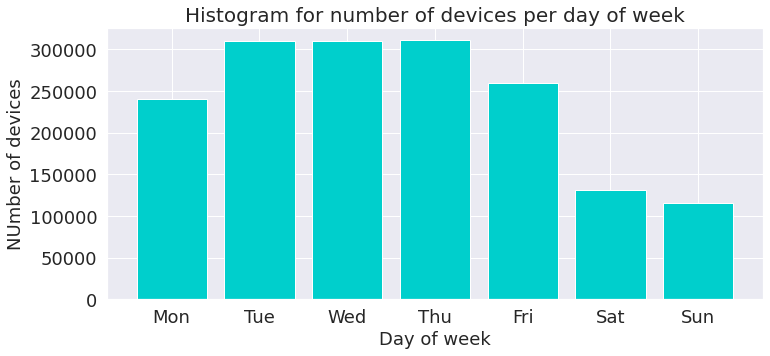

In [ ]:
data_merged['day_week_name'] = data_merged.received_at.dt.day_name().astype(str).str.slice(start=0, stop=3)
data_merged['day_week'] = data_merged.received_at.dt.weekday

# Get the number of devices day
group2 = data_merged.groupby(['day_week','day_week_name']).count().reset_index()[['day_week','day_week_name','nd']].sort_values(by=['day_week'])

f, axs = plt.subplots(1,1,figsize=(40,5))
plt.subplot(1, 3, 1)
plt.bar(group2.day_week_name, group2.nd,alpha = 1, color=colors[0])
plt.xlabel('Day of week', fontsize=18)
plt.ylabel('NUmber of devices', fontsize=18)
plt.title(r'Histogram for number of devices per day of week', fontsize=20)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)

(array([    0., 10000., 20000., 30000., 40000., 50000., 60000., 70000.,
        80000.]), <a list of 9 Text major ticklabel objects>)

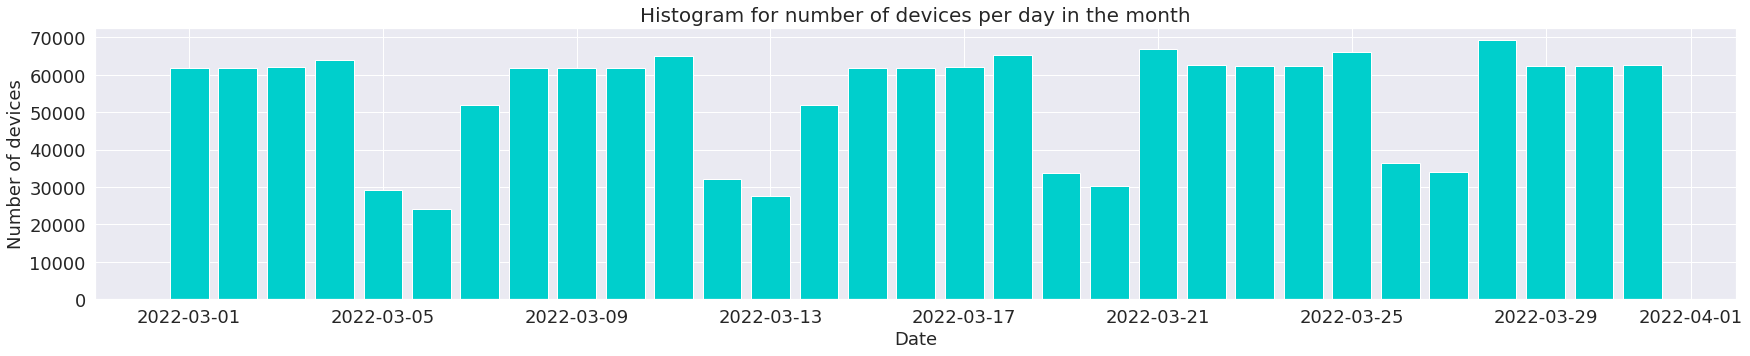

In [ ]:
data_merged['date'] = data_merged.received_at.dt.date

# Get the number of devices day
group2 = data_merged.groupby(['date']).count().reset_index()[['date','nd']].sort_values(by=['date'])

f, axs = plt.subplots(1,1,figsize=(100,5))
plt.subplot(1, 3, 1)
plt.bar(group2.date, group2.nd,alpha = 1, color=colors[0])
plt.xlabel('Date', fontsize=18)
plt.ylabel('Number of devices', fontsize=18)
plt.title(r'Histogram for number of devices per day in the month', fontsize=20)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)

(array([     0.,  20000.,  40000.,  60000.,  80000., 100000., 120000.]),
 <a list of 7 Text major ticklabel objects>)

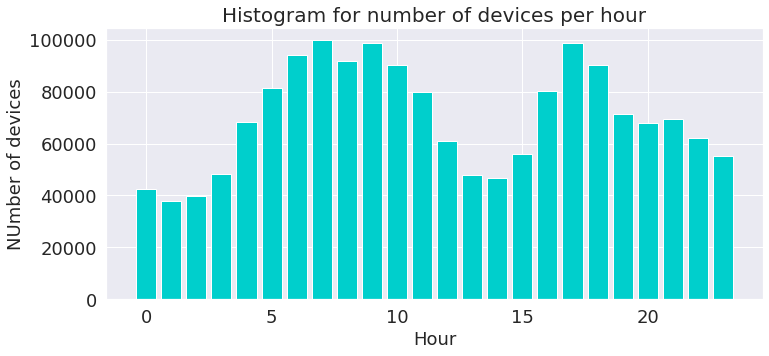

In [ ]:
data_merged['hour'] = data_merged.received_at.dt.hour

# Get the number of devices day
group3 = data_merged.groupby(['hour']).count().reset_index()[['hour','nd']]

f, axs = plt.subplots(1,1,figsize=(40,5))
plt.subplot(1, 3, 1)
plt.bar(group3.hour, group3.nd,alpha = 1, color=colors[0])
plt.xlabel('Hour', fontsize=18)
plt.ylabel('NUmber of devices', fontsize=18)
plt.title(r'Histogram for number of devices per hour', fontsize=20)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)

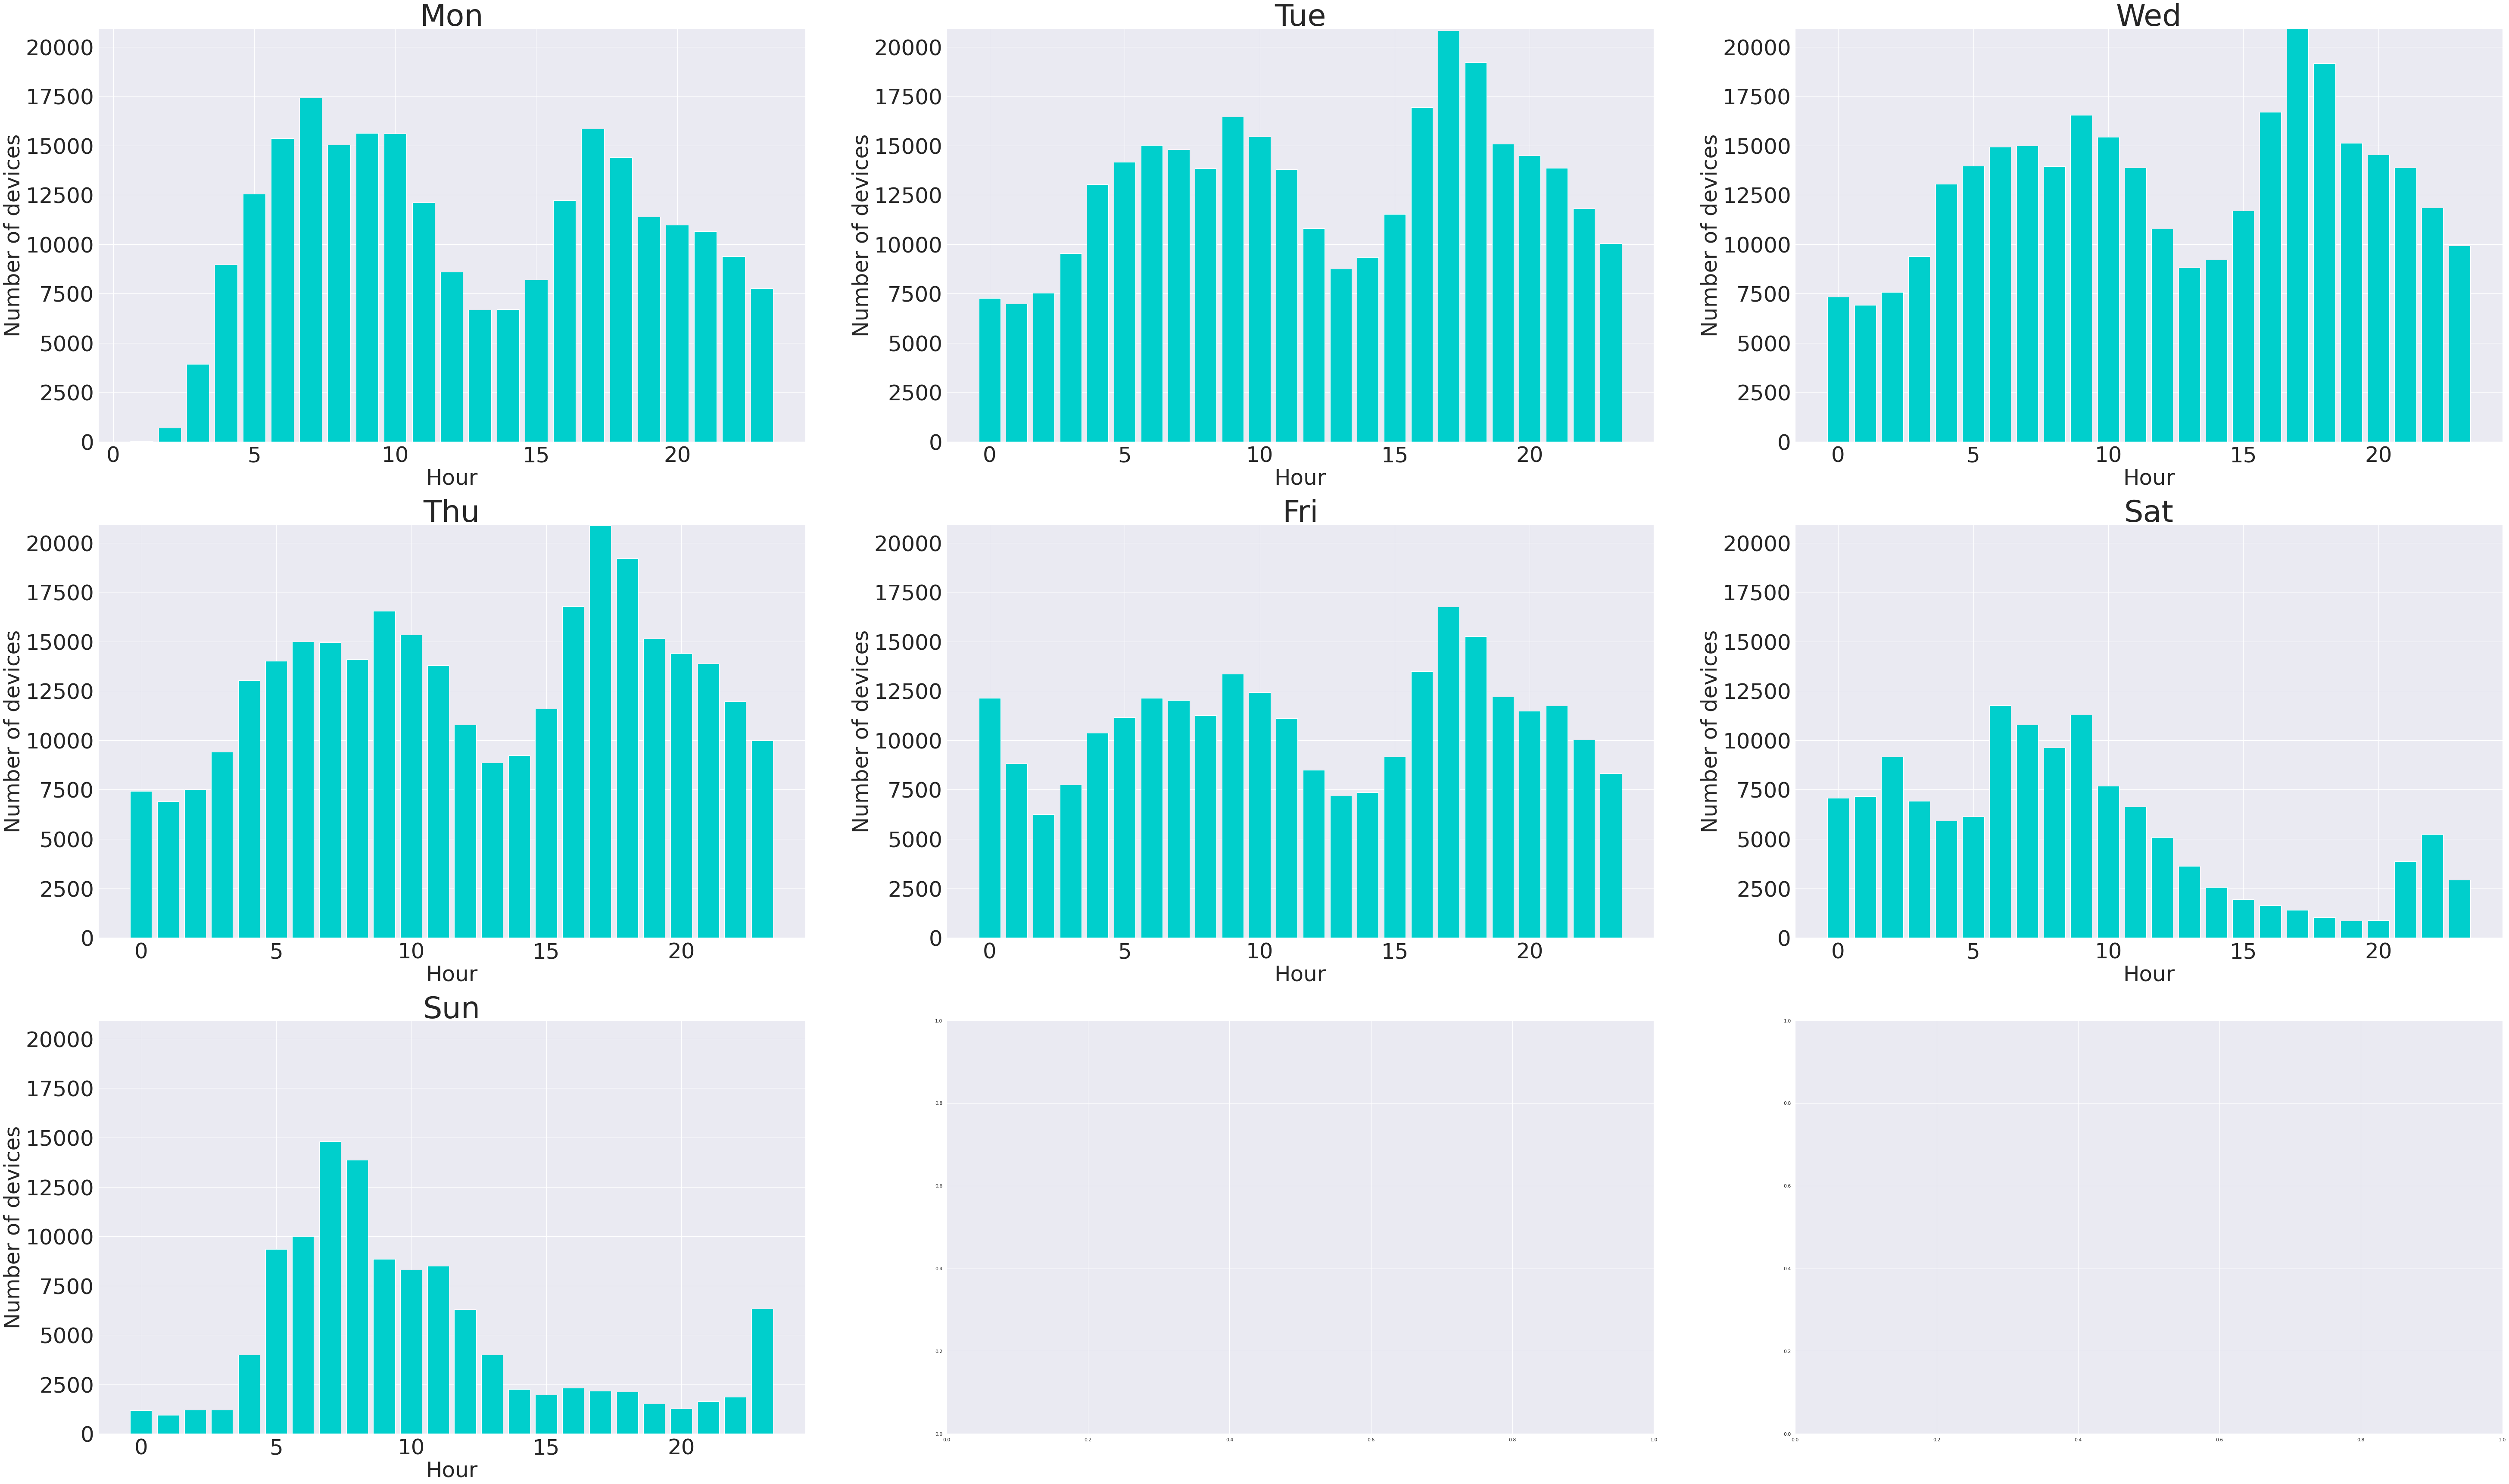

In [ ]:
# Get the number of devices day
group4 = data_merged.groupby(['day_week','day_week_name','hour']).count().reset_index()[['day_week','day_week_name','hour','nd']]

f, axs = plt.subplots(3,3,figsize=(100,60))

for i in range(len(group4.day_week_name.unique())):
  plt.subplot(3, 3, i + 1)
  plt.bar(group4.loc[group4['day_week_name'] == group4.day_week_name.unique()[i]].hour, group4.loc[group4['day_week_name'] == group4.day_week_name.unique()[i]].nd,alpha = 1, color=colors[0])
  plt.xlabel('Hour', fontsize=50)
  plt.ylabel('Number of devices', fontsize=50)
  plt.title(group4.day_week_name.unique()[i], fontsize=70)
  plt.xticks(fontsize=50)
  plt.yticks(fontsize=50)
  plt.ylim(0, max(group4.nd) + 20)
  


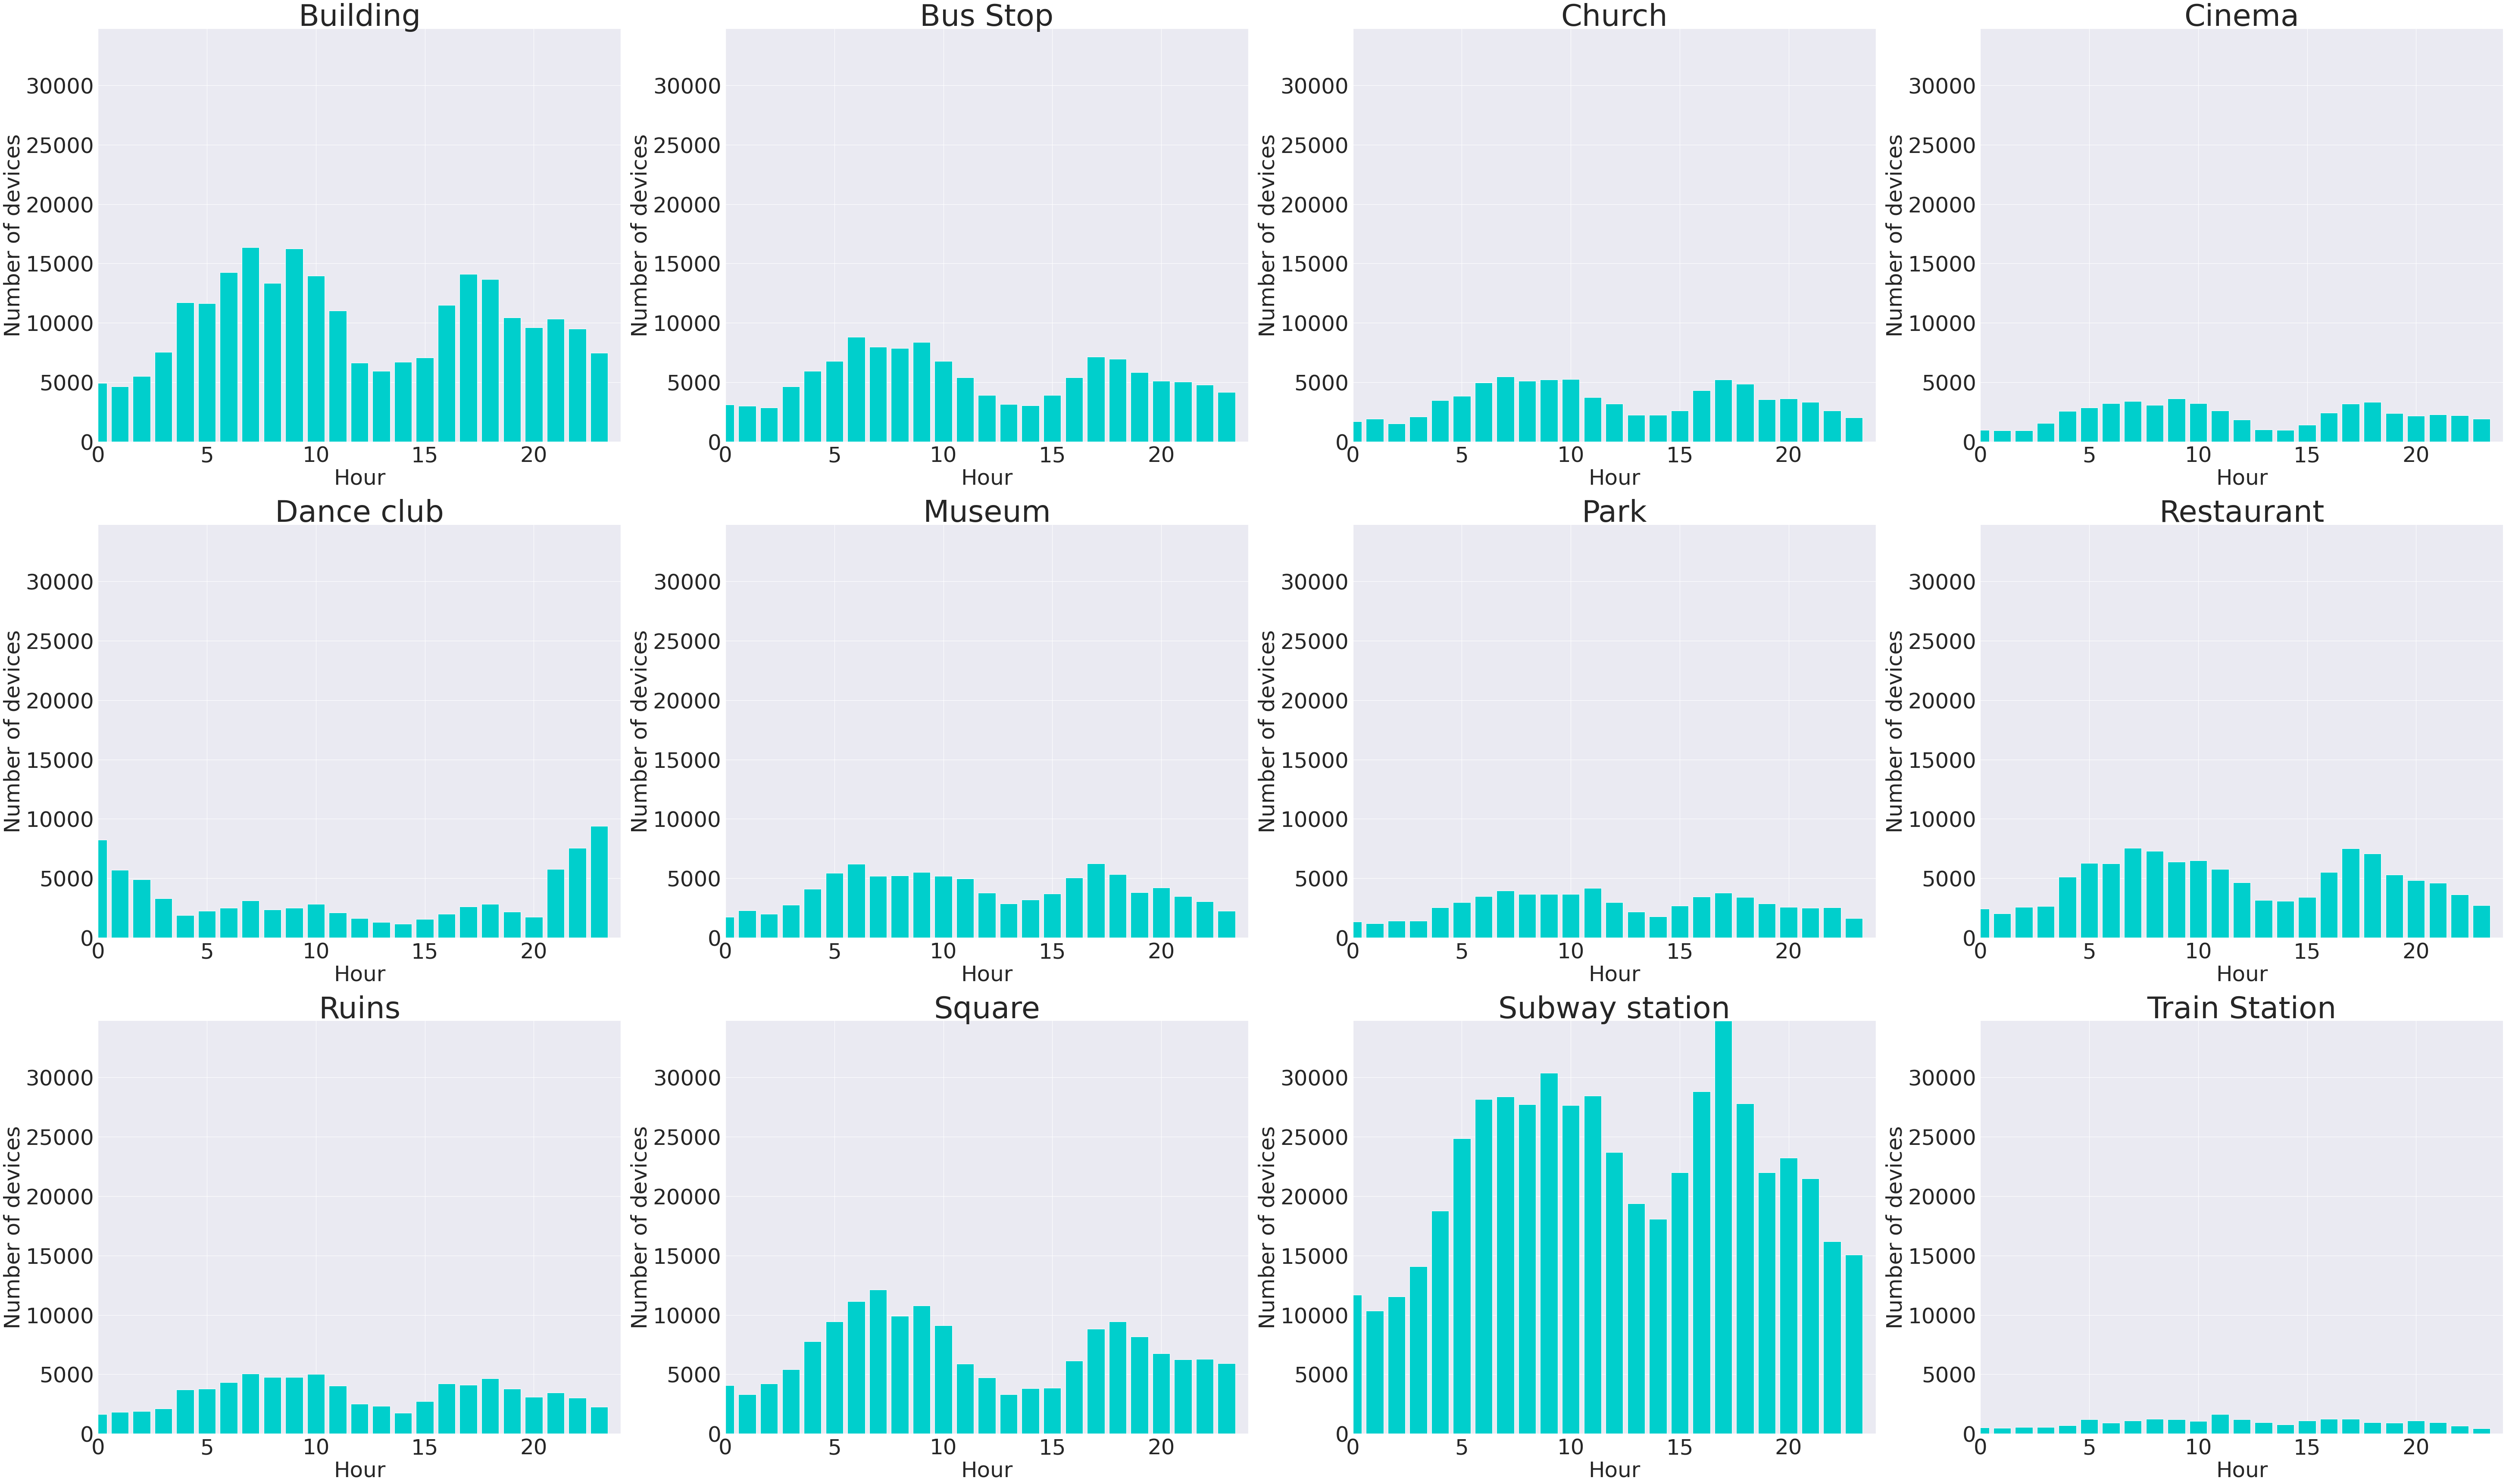

In [ ]:
# Get the number of devices day
group5 = data_merged.groupby(['type','hour']).count().reset_index()[['type','hour','nd']]

f, axs = plt.subplots(3,4,figsize=(100,60))

for i in range(len(group5.type.unique())):
  plt.subplot(3, 4, i + 1)
  plt.bar(group5.loc[group5['type'] == group5.type.unique()[i]].hour, group5.loc[group5['type'] == group5.type.unique()[i]].nd,alpha = 1, color=colors[0])
  plt.xlabel('Hour', fontsize=50)
  plt.ylabel('Number of devices', fontsize=50)
  plt.title(group5.type.unique()[i], fontsize=70)
  plt.xticks(fontsize=50)
  plt.yticks(fontsize=50)
  plt.ylim(0, max(group5.nd) + 20)
  plt.xlim(0, 24)
  


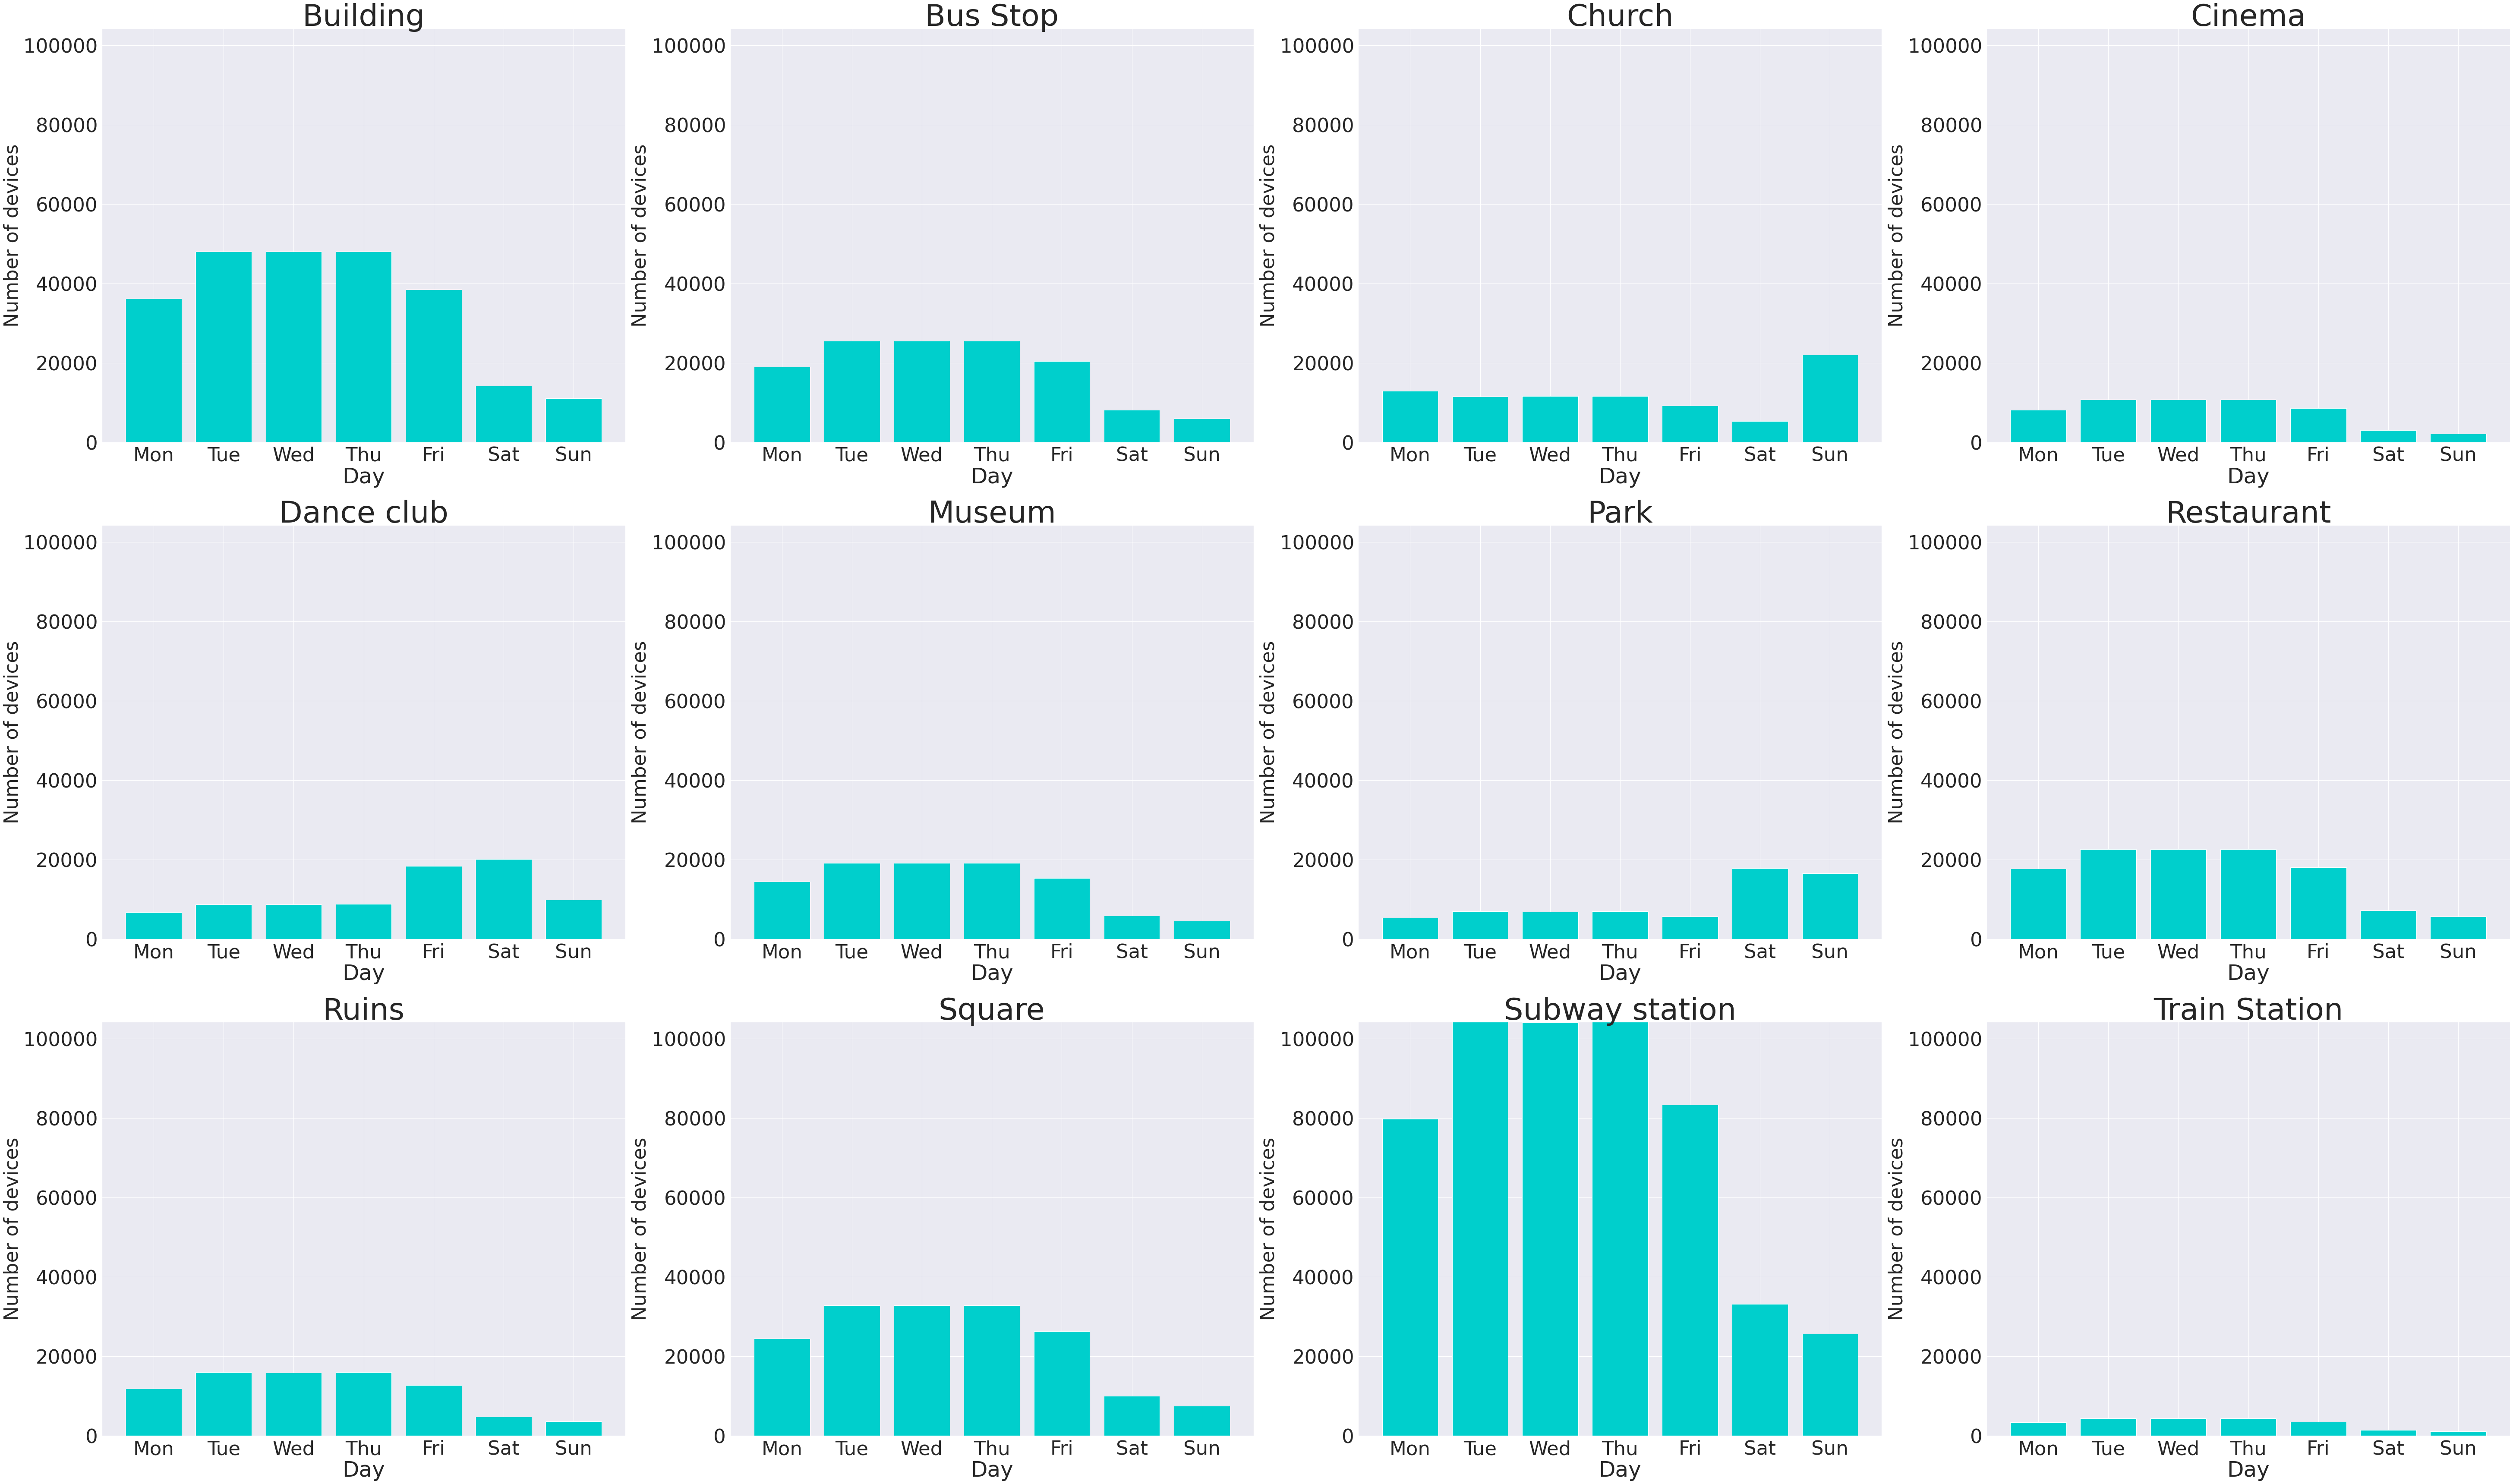

In [ ]:
# Get the number of devices per type and day
group6 = data_merged.groupby(['day_week','day_week_name','type']).count().reset_index()[['day_week','day_week_name','type','nd']]

f, axs = plt.subplots(3,4,figsize=(100,60))

for i in range(len(group6.type.unique())):
  plt.subplot(3, 4, i + 1)
  plt.bar(group6.loc[group6['type'] == group6.type.unique()[i]].day_week_name, group6.loc[group6['type'] == group6.type.unique()[i]].nd,alpha = 1, color=colors[0])
  plt.xlabel('Day', fontsize=50)
  plt.ylabel('Number of devices', fontsize=45)
  plt.title(group6.type.unique()[i], fontsize=70)
  plt.xticks(fontsize=45)
  plt.yticks(fontsize=45)
  plt.ylim(0, max(group6.nd) + 20)
  

([0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25,
  26,
  27,
  28,
  29],
 <a list of 30 Text major ticklabel objects>)

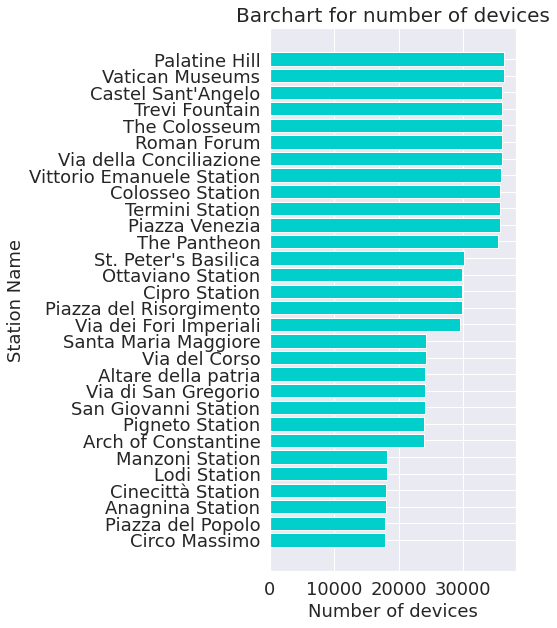

In [ ]:
# Get the number of devices per station
group7 = data_merged.groupby(['place_name','station_id']).count().reset_index()[['place_name','station_id','nd']].sort_values(by=['nd'], ascending = True)

f, axs = plt.subplots(1,1,figsize=(15,10))
plt.subplot(1, 3, 1)
plt.barh(group7.tail(30).place_name, group7.tail(30).nd,alpha = 1, color=colors[0])
plt.xlabel('Number of devices', fontsize=18)
plt.ylabel('Station Name', fontsize=18)
plt.title(r'Barchart for number of devices', fontsize=20)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)

Text(0.5, 1.0, 'Histogram for number of different stations visited per device')

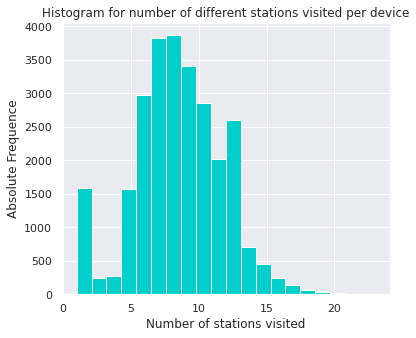

In [ ]:
# Get the number devices in each different station
group8 = data_merged.drop_duplicates(['station_id','place_name','fingerprint_id']).groupby(['fingerprint_id']).count().reset_index()[['fingerprint_id','nd']].sort_values(by=['nd'], ascending = True)

f, axs = plt.subplots(1,1,figsize=(20,5))
plt.subplot(1, 3, 1)
plt.hist(group8.nd,alpha = 1, label='Train', bins = 20, color=colors[0])
plt.xlabel('Number of stations visited')
plt.ylabel('Absolute Frequence')
plt.title(r'Histogram for number of different stations visited per device')

# Experimentations with distributions

With the following cells, I made some experiments to define some parameters of the data generation. In that way, I managed to control and see what the shape of the data could look like.

Mean theorical: 10.0
Standard Deviation theorical: 3.1622776601683795
Mean empirical: 9.955551371711012
Median : 9.735714851179324
Standard Deviation empirical: 3.0195427649436875
Min: 3.2606100754778256
Max: 20.706264627981685


Text(0.5, 1.0, 'Histogram for Hours of the day')

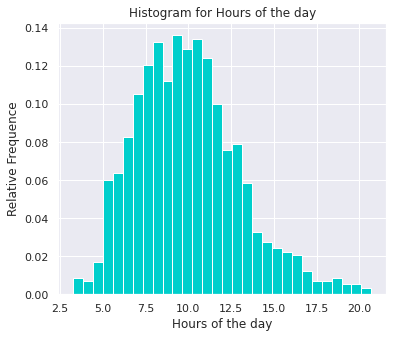

In [ ]:
shape = 10
mu_desired = 10
scale = mu_desired / shape
mu_gamma_theo = shape / (1/scale)
sd_gamma_theo = np.sqrt(shape / (1/scale)**2)

np.random.seed(random_state)
random_numbers = np.random.gamma(shape, scale, 1000)
# random_numbers = normalize_hours(random_numbers, 0, 24)


print('Mean theorical:',mu_gamma_theo)
print('Standard Deviation theorical:',sd_gamma_theo)
print("Mean empirical:",np.mean(random_numbers))
print("Median :",np.median(random_numbers))
print("Standard Deviation empirical:",np.std(random_numbers))
print("Min:",np.min(random_numbers))
print("Max:",np.max(random_numbers))

f, axs = plt.subplots(1,1,figsize=(20,5))
plt.subplot(1, 3, 1)
plt.hist(random_numbers,alpha = 1, label='Train', density=True, bins = 30, color=colors[0])
plt.xlabel('Hours of the day')
plt.ylabel('Relative Frequence')
plt.title(r'Histogram for Hours of the day')

Mean theorical: 5.0
Standard Deviation theorical: 7.905694150420948
Mean empirical: 6.111664012177891
Median : 2.7532333827028674
Standard Deviation empirical: 8.433601358901477
Min: 1.0000001421305966
Max: 61.065887356507105


Text(0.5, 1.0, 'Histogram for speed')

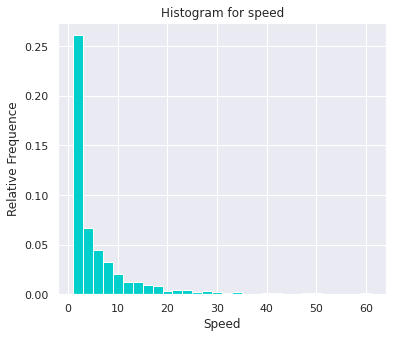

In [ ]:
shape = 0.4
mu_desired = 5
scale = mu_desired / shape
mu_gamma_theo = shape / (1/scale)
sd_gamma_theo = np.sqrt(shape / (1/scale)**2)

np.random.seed(random_state)
random_numbers = np.random.gamma(shape, scale, 1000) + 1
# random_numbers = normalize_hours(random_numbers, 6, 24)


print('Mean theorical:',mu_gamma_theo)
print('Standard Deviation theorical:',sd_gamma_theo)
print("Mean empirical:",np.mean(random_numbers))
print("Median :",np.median(random_numbers))
print("Standard Deviation empirical:",np.std(random_numbers))
print("Min:",np.min(random_numbers))
print("Max:",np.max(random_numbers))

f, axs = plt.subplots(1,1,figsize=(20,5))
plt.subplot(1, 3, 1)
plt.hist(random_numbers,alpha = 1, label='Train', density=True, bins = 30, color=colors[0])
plt.xlabel('Speed')
plt.ylabel('Relative Frequence')
plt.title(r'Histogram for speed')

# Format data to have the SQLite schema defined and populated

Once the data was generated, it was a requirement of Massimo to have it saved in SQLite format, since the real data will be stored into the same format. That step is done over the following code.

In [ ]:
start_time = time.time()

conn = sqlite3.connect('data/BLE_synthetic_DB.db')

conn.execute('''DROP TABLE georeference''')
conn.execute('''DROP TABLE data''')
conn.execute('''DROP TABLE payload''')
conn.execute('''DROP TABLE fingerprintblock''')

# georeference table creation
conn.execute('''CREATE TABLE georeference 
                (station_id VARCHAR NOT NULL,
                device_id VARCHAR NOT NULL,
                latitude VARCHAR NOT NULL DEFAULT "0.0",
                longitude VARCHAR NOT NULL DEFAULT "0.0",
                place_name VARCHAR NOT NULL,
                address VARCHAR NOT NULL,
                PRIMARY KEY(station_id, device_id),
                CONSTRAINT pmk_unique UNIQUE(station_id, device_id)
                );''')

# data table creation
conn.execute('''CREATE TABLE data 
                (id INTEGER PRIMARY KEY AUTOINCREMENT, 
                device_id VARCHAR NOT NULL, 
                received_at DATE NOT NULL, 
                payload_hexstring VARCHAR, 
                json_string VARCHAR, 
                FOREIGN KEY(device_id) REFERENCES georeference(device_id));''')

# payload table creation
conn.execute('''CREATE TABLE payload 
                (payload_id INTEGER PRIMARY KEY AUTOINCREMENT, 
                data_id INTEGER NOT NULL, 
                station_id INTEGER NOT NULL, 
                utc_timestamp INTEGER NOT NULL, 
                nd INTEGER NOT NULL, 
                nf INTEGER NOT NULL, 
                FOREIGN KEY(data_id) REFERENCES data(id));''')

# fingerprintblock table creation
conn.execute('''CREATE TABLE fingerprintblock 
                (fingerprintblock_id INTEGER PRIMARY KEY AUTOINCREMENT, 
                payload_id INTEGER NOT NULL, 
                timeslot INTEGER NOT NULL, 
                fingerprint VARCHAR NOT NULL, 
                FOREIGN KEY(payload_id) REFERENCES payload(payload_id) );''')


### Create table georeference to populate SQL database ###
georeference = data_merged.drop_duplicates(['station_id'])[['station_id','device_id','latitude','longitude','place_name','address']].copy()
georeference.latitude = georeference.latitude.astype(str)
georeference.longitude = georeference.longitude.astype(str)

### Create table data to populate SQL database ###
data = data_merged[['device_id','received_at']].copy()
data['received_at'] = data['received_at'].dt.round('min')
data = data.groupby(['device_id','received_at']).count().reset_index()[['device_id','received_at']]
data['payload_hexstring'] = ''
data['json_string'] = ''

### Create table payload to populate SQL database ###
payload = data_merged[['station_id','received_at','nd']].copy()
payload['received_at'] = payload['received_at'].dt.round('min')
payload = payload.groupby(['station_id','received_at']).count().reset_index()[['station_id','received_at','nd']]
payload['data_id'] = payload.index + 1


# Get number of distinct fingerprints
fingerprints = data_merged.copy()
fingerprints['received_at'] = fingerprints['received_at'].dt.round('min')
fingerprints = fingerprints.drop_duplicates(['station_id','fingerprint_id','received_at'])[['station_id','fingerprint_id','received_at','nd']]
fingerprints = payload.groupby(['station_id','received_at']).count().reset_index()[['station_id','received_at','nd']]
fingerprints.rename(columns = {'nd':'nf'}, inplace = True)
payload = pd.merge(payload,fingerprints,on=['station_id','received_at'],how='left')

# Select columns
payload['utc_timestamp'] = pd.DatetimeIndex(payload['received_at']).view(np.int64)/1000000
payload = payload[['data_id','station_id','utc_timestamp','nd','nf']]

### Create table fingerprintblock to populate SQL database ###
fingerprints = data_merged.copy()
fingerprints['received_at'] = fingerprints['received_at'].dt.round('min')
fingerprints = fingerprints[['station_id','fingerprint_id','received_at','nd']]
fingerprints['utc_timestamp'] = pd.DatetimeIndex(fingerprints['received_at']).view(np.int64)/1000000
fingerprintblock = pd.merge(payload,fingerprints,on=['station_id','utc_timestamp'],how='left')
# Simulate the time slot randomly
np.random.seed(random_state)
fingerprintblock['timeslot'] = np.random.randint(0, 255, fingerprintblock.shape[0])
fingerprintblock.rename(columns = {'data_id':'payload_id','fingerprint_id':'fingerprint'}, inplace = True)
# Select columns
fingerprintblock = fingerprintblock[['payload_id','timeslot','fingerprint']]

### Insert rows to SQLite tables ###
georeference.to_sql('georeference', con=conn, if_exists='append',index=False)
data.to_sql('data', con=conn, if_exists='append',index=False)
payload.to_sql('payload', con=conn, if_exists='append',index=False)
fingerprintblock.to_sql('fingerprintblock', con=conn, if_exists='append',index=False)
conn.close()
print("Execution time: %s seconds" % (time.time() - start_time))

Execution time: 63.66481900215149 seconds


In [ ]:
# len(np.unique(data_merged.fingerprint_id.str[:10]))
# conn = sqlite3.connect('data/BLE_synthetic_DB.db')
# test = pd.read_sql_query('''SELECT * FROM data dt INNER JOIN georeference gr ON dt.device_id = gr.device_id''', conn)
# conn.close()
# test